In [90]:
import pandas as pd
import numpy as np 
import random
import os 
import sys 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib 
import json
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay


In [91]:
# Get the current working directory
current_working_directory = os.getcwd()

# Construct the path to the 1D_radiomics/utils directory
utils_path = os.path.abspath(os.path.join(current_working_directory, '..', '1D_radiomics', 'utils'))

# Add the path to sys.path
sys.path.append(utils_path)

# Now you can import your module
import src.feature_selection as fsa 
import src.dataset as dataset
import src.test as test
import src.train as train
from src import analysis_functions

# Test ICM models

In [92]:
np.random.seed(42)
random.seed(42)
print("Seed example = ", random.randint(0, 100))

Seed example =  81


# One year local recurrence

## Load data

### ICM config

In [93]:

params = dataset.load_config('/home/tachennf/Documents/delta-rad/1D_radiomics/full_training_settings.yaml')

icm_folder_path = '/home/tachennf/Documents/delta-rad/data/ICM_0.35T/extracted_radiomics/'
icm_outcome_csv = icm_folder_path + 'one_year_local_control_status.csv'
icm_results_file = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/json_results/full_training_mridian.json'
models_folder = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/models/one_year_local_control_status/'



###  Madrid config

In [94]:
madrid_folder_path = '/home/tachennf/Documents/delta-rad/data/Madrid/combat_csv/'
madrid_outcome_csv = madrid_folder_path + 'one_year_local_control_status.csv'
madrid_results_file = '/home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian.json'

###  Common config

In [95]:
delta_rad_tables = params['paths']['delta_rad_tables']
outcomes_list = ['one_year_local_control_status']
feat_sel_algo_list = ['ANOVA_K_BEST', 'RF']
pred_algo_list = params['parameters']['pred_algo_list']
max_features = params['parameters']['max_features']
smote = params['parameters']['smote']
models_folder = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/models/one_year_local_control_status/'

### Madrid functions

In [96]:
def load_selected_features(results_file: str, table: str, fs_algo: str, pred_algo: str, outcome: str, nb_features: int): 
    """
    Load the selected features from the results file.

    Parameters
    ----------
    results_file : str
        Path to the results file.
    table : str
        Name of the table.
    fs_algo : str
        Feature selection algorithm.
    pred_algo : str 
        Prediction algorithm.
    outcome : str
        Outcome variable.
    nb_features : int
        Number of features to select.

        Returns
        -------
        list
            List of selected features.
    """
    results = json.load(open(results_file))
    return results[table][fs_algo][pred_algo][outcome][str(nb_features)]['features']


In [97]:
def get_xy(rad_csv_path: str, outcome_csv_path: str):
    """
    Load and preprocess dataset for training and validation.

    Parameters:
    rad_csv_path (str): Path to the radiomics CSV file.
    outcome_csv_path (str): Path to the outcome CSV file.
    
    Returns:
    tuple: A tuple containing:
        - X (pd.DataFrame): Features.
        - y (pd.DataFrame): Labels.
        - features_list (pd.Index): List of feature names.
    """

    X = pd.read_csv(rad_csv_path, index_col=0)
    X = X.dropna() # delete nan values

    y = pd.read_csv(outcome_csv_path, index_col=0)
    y = y.dropna() # delete nan values

    return X, y, X.columns

## Test models

In [98]:
results = test.def_results_dict(delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcomes_list, max_features)
for table in delta_rad_tables:
    print('Testing model on table ', table)
    for outcome in outcomes_list: 
        X_icm, y_icm, icm_features_list = dataset.get_xy(os.path.join(icm_folder_path, table), os.path.join(icm_folder_path, icm_outcome_csv), outcome, smote=smote) # Load the dataset 
        X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
        for fs_algo in feat_sel_algo_list:
            if 'CHI2' in fs_algo:
                min_max_scaler = MinMaxScaler()
                X_icm = min_max_scaler.fit_transform(X_icm)
                X_madrid = min_max_scaler.fit_transform(X_madrid)
            else:     
                znorm_scaler = StandardScaler()
                X_icm = znorm_scaler.fit_transform(X_icm)
                X_madrid = znorm_scaler.fit_transform(X_madrid)
            
            for nb_features in range(1, max_features+1): # number of features selected
                best_features = load_selected_features(icm_results_file, table, fs_algo, 'RF', outcome, nb_features) # get previously selected features
                sel_features_icm, X_filtered_icm = fsa.filter_dataset3(X_icm, best_features, nb_features, icm_features_list) # filter dataset based on selected features
                sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)
                for pred_algo in pred_algo_list:
                    model_path = models_folder + table + "_" + fs_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
                    loaded_model = joblib.load(model_path)
                    y_icm = np.array(y_icm).reshape(-1, 1).ravel() # convert to numpy array to avoid errors
                    y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array
                    optimal_threshold, train_auc, train_brier_loss = train.compute_opt_threshold(loaded_model, X_filtered_icm, y_icm) # compute optimal threshold based on train set results
                    brier_loss, brier_loss_ci, test_auc, test_auc_ci, sensitivity, sensitivity_ci, specificity, specificity_ci = test.compute_test_metrics(loaded_model, X_filtered_madrid, y_madrid, optimal_threshold) # compute test metrics on Madrid data 
                    results = test.save_results(results, table, fs_algo, pred_algo, outcome, sel_features_madrid, train_auc, train_brier_loss, test_auc, sensitivity, specificity, brier_loss, test_auc_ci, sensitivity_ci, specificity_ci, brier_loss_ci) # save metrics
                    results[table][fs_algo][pred_algo][outcome][nb_features]['features'] = sel_features_madrid


results_ser = dataset.convert_to_list(results)
with open(madrid_results_file, 'w') as f: 
    json.dump(results_ser, f)                     
print("Results saved in {} file.".format(madrid_results_file))    

Testing model on table  simu_gtv.csv
Testing model on table  f1_gtv.csv
Testing model on table  f3_gtv.csv
Testing model on table  f5_gtv.csv
Testing model on table  simu_f1_gtv.csv
Testing model on table  simu_f3_gtv.csv
Testing model on table  simu_f5_gtv.csv
Testing model on table  f1_f3_gtv.csv
Testing model on table  f1_f5_gtv.csv
Results saved in /home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian.json file.


## Analyze results

In [99]:
nice_tables = ['SIMU', 'F1', 'F3', 'F5', 'Simu_F1', 'Simu_F3', 'Simu_F5', 'F1_F3', 'F1_F5']
results = pd.read_json(madrid_results_file)
results_dict = json.load(open(madrid_results_file))
print(results_dict.keys())  
print(pred_algo_list)
print(feat_sel_algo_list)

dict_keys(['simu_gtv.csv', 'f1_gtv.csv', 'f3_gtv.csv', 'f5_gtv.csv', 'simu_f1_gtv.csv', 'simu_f3_gtv.csv', 'simu_f5_gtv.csv', 'f1_f3_gtv.csv', 'f1_f5_gtv.csv'])
['RF', 'ADABOOST', 'LOGREGRIDGE', 'PSVM', 'KNN', 'BAGG', 'QDA']
['ANOVA_K_BEST', 'RF']


### Compare one algo with different metrics and CI

In [100]:
pred_algo = "QDA"
feat_sel_algo = "RF"
outcome = "one_year_local_control_status"
table = 'simu_f3_gtv.csv'
print(results[table][feat_sel_algo][pred_algo])
inter_res = results[table][feat_sel_algo][pred_algo][outcome]
#for table in delta_rad_tables: 
for nb_features in inter_res.keys():
    print(nb_features, inter_res[nb_features]['features'])
    print("Train AUC: ", np.mean(inter_res[nb_features]['train_metrics']['auc']['values']))
    print("Test AUC: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['auc']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[1]))
    print("Test Brier loss: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['brier_loss']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[1]))
    print("Test sensitivity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['sensitivity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[1]))
    print("Test specificity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['specificity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[1]))
    print('')


{'one_year_local_control_status': {'1': {'features': ['original_shape_Maximum2DDiameterSlice'], 'params': {}, 'train_metrics': {'auc': {'values': [0.8676658163265301], 'conf_int': []}, 'brier_loss': {'values': [0.18523581561913502], 'conf_int': []}}, 'test_metrics': {'auc': {'values': [0.747069747150304], 'conf_int': [[0.49859375, 0.9358870967741931]]}, 'sensitivity': {'values': [0.8], 'conf_int': [[0.8, 0.8]]}, 'specificity': {'values': [0.40625000000000006], 'conf_int': [[0.40625000000000006, 0.40625000000000006]]}, 'brier_loss': {'values': [0.25459387871051803], 'conf_int': [[0.182329420558728, 0.33104194321950503]]}}}, '2': {'features': ['original_shape_Maximum2DDiameterSlice', 'original_glszm_LargeAreaHighGrayLevelEmphasis'], 'params': {}, 'train_metrics': {'auc': {'values': [0.882334183673469], 'conf_int': []}, 'brier_loss': {'values': [0.14273659327750002], 'conf_int': []}}, 'test_metrics': {'auc': {'values': [0.5875360447258581], 'conf_int': [[0.29538770053475905, 0.85791316526

### Plot Calibration curve

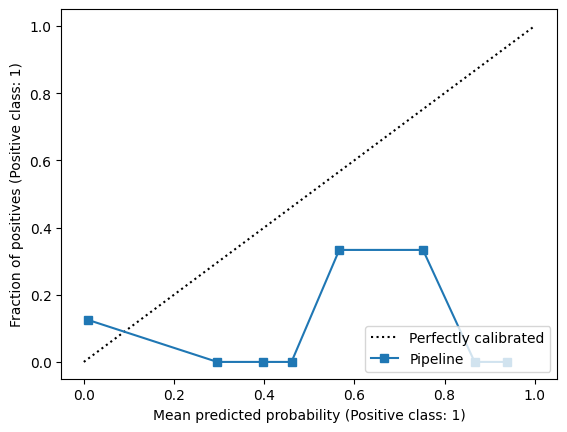

In [101]:
nb_features = 3

# load data 
X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
znorm_scaler = StandardScaler()
X_madrid = znorm_scaler.fit_transform(X_madrid)
best_features = load_selected_features(icm_results_file, table, feat_sel_algo, pred_algo, outcome, nb_features) # get previously selected features
sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)
model_path = models_folder + table + "_" + feat_sel_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
loaded_model = joblib.load(model_path)
y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array

# calibration curve
CalibrationDisplay.from_estimator(loaded_model, X_filtered_madrid, y_madrid, n_bins=10)


### Best train AUC
#### Display

In [102]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='train_auc')

Table: simu_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_ngtdm_Busyness', 'original_glcm_Imc1'], Parameters: {}
  Mean train_auc: 0.996, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: ADABOOST, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness'], Parameters: {}
  Mean train_auc: 0.988, Feature Selection Algorithm: RF, Prediction Algorithm: ADABOOST, Features: ['original_shape_Sphericity', 'original_ngtdm_Busyness', 'original_glcm_Imc1'], Parameters: {}

Table: f1_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterRow', 'original_glcm_Imc1'], Parameters: {}
  Mean train_auc: 0.975, Feature Selection Algorithm: RF, Prediction Algorithm: RF, Features: ['original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterRow', 'original_glcm

#### Scatter plot

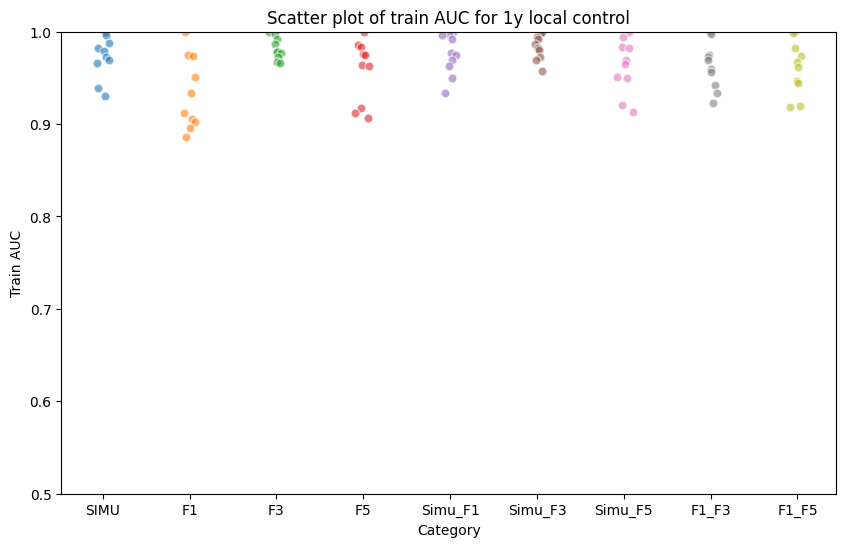

In [103]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train AUC')
plt.show()


### Best train Brier loss
#### Display

In [104]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_brier_loss', k = 10)
analysis_functions.print_top_results(top_results, metric='train_brier_loss')

Table: simu_gtv.csv
  Mean train_brier_loss: 0.02, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_ngtdm_Busyness', 'original_glcm_Imc1'], Parameters: {}
  Mean train_brier_loss: 0.021, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_Sphericity', 'original_ngtdm_Busyness'], Parameters: {}
  Mean train_brier_loss: 0.024, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness', 'original_shape_Sphericity'], Parameters: {}

Table: f1_gtv.csv
  Mean train_brier_loss: 0.021, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterRow', 'original_glcm_Imc1'], Parameters: {}
  Mean train_brier_loss: 0.025, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_firstorder_Kurtosis', 'original_shap

#### Scatter plot

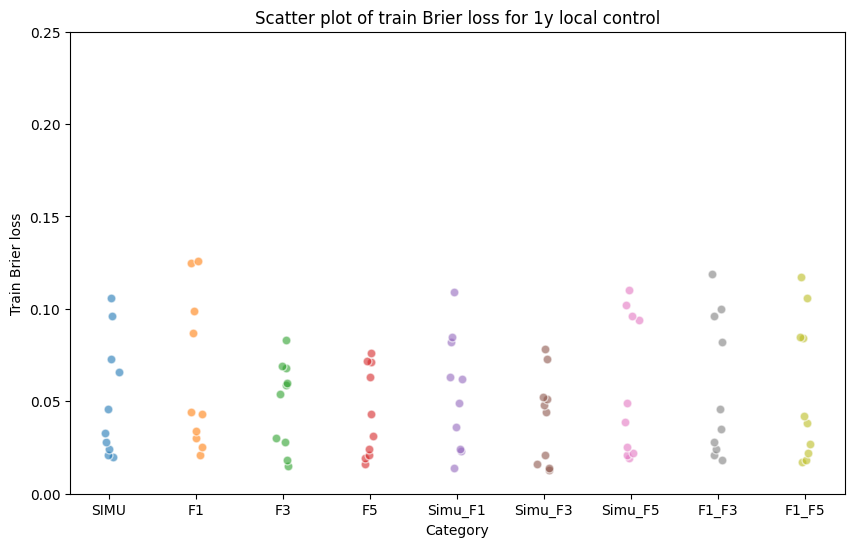

In [105]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train Brier loss for 1y local control')
plt.ylim([0, 0.25])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train Brier loss')
plt.show()


### Best test AUC
#### Display

In [106]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='test_auc')

Table: simu_gtv.csv
  Mean test_auc: 0.798, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness'], Parameters: {}
  Mean test_auc: 0.734, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_shape_Sphericity', 'original_ngtdm_Busyness'], Parameters: {}
  Mean test_auc: 0.718, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}

Table: f1_gtv.csv
  Mean test_auc: 0.763, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_auc: 0.723, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_firstorder_Kurtosis'], Parameters: {}
  Mean test_auc: 0.698, Feature Selection Algorithm: RF, Prediction Algorithm: QDA, Features: ['original_firstorder_K

#### Scatter plot

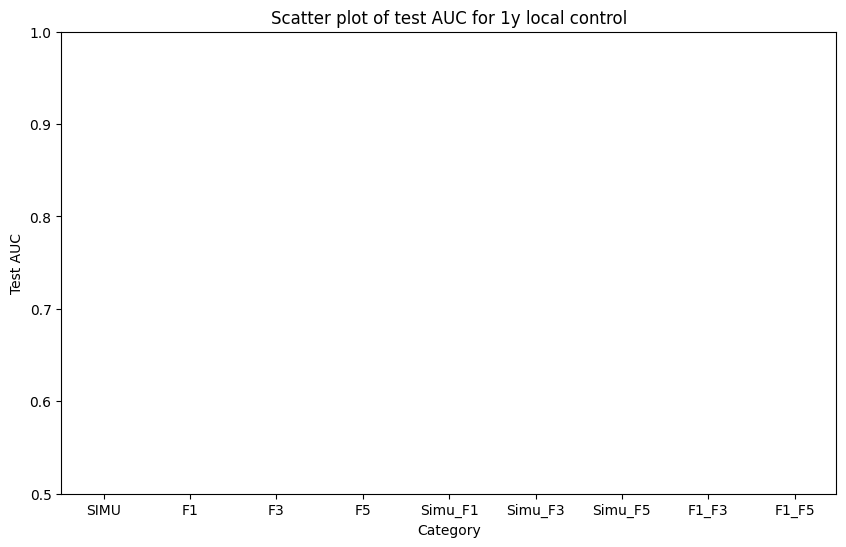

In [107]:
plt.figure(figsize=(10, 6))

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test AUC')
plt.show()


### Best test brier loss
#### Display

In [108]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_brier_loss', k = 3)
analysis_functions.print_top_results(top_results, metric='test_brier_loss', k = 3)

Table: simu_gtv.csv
  Mean test_brier_loss: 0.217, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_brier_loss: 0.218, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: RF, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness', 'original_shape_Sphericity'], Parameters: {}
  Mean test_brier_loss: 0.228, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: ADABOOST, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_Flatness', 'original_shape_Sphericity'], Parameters: {}

Table: f1_gtv.csv
  Mean test_brier_loss: 0.173, Feature Selection Algorithm: RF, Prediction Algorithm: RF, Features: ['original_firstorder_Kurtosis'], Parameters: {}
  Mean test_brier_loss: 0.174, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterRow'], Parameters: {}
  Me

#### Scatter plot

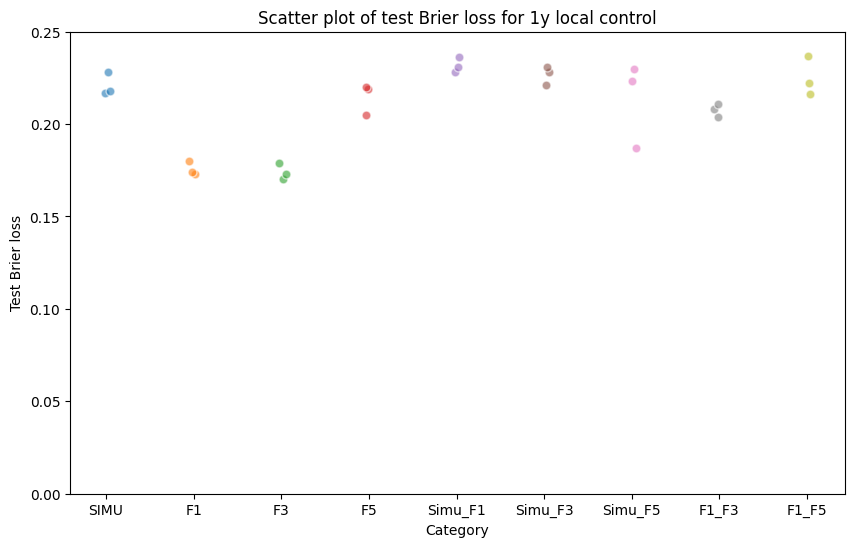

In [109]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test Brier loss for 1y local control')
plt.ylim([0, 0.25])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test Brier loss')
plt.show()


### Best spe & sens

In [110]:
analysis_functions.find_perf_alg(results, delta_rad_tables, [outcome], feat_sel_algo_list, pred_algo_list, metric='sens_spec', threshold=0.65)

Table: simu_f3_gtv.csv, Outcome: one_year_local_control_status, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: KNN, Number of Features: 3, '
'                                           TEST AUC: 0.713337902993463, Sensitivity: 0.8, Specificity: 0.65625, '
'                                           Features: ['original_glcm_Idn', 'original_gldm_DependenceNonUniformity', 'original_shape_Maximum2DDiameterSlice']


# Metastatic recurrence
## Load data

### Config ICM

In [58]:

params = dataset.load_config('/home/tachennf/Documents/delta-rad/1D_radiomics/full_training_settings.yaml')

icm_folder_path = '/home/tachennf/Documents/delta-rad/data/ICM_0.35T/extracted_radiomics/'
icm_outcome_csv = icm_folder_path + 'nine_months_metastatic_status.csv'
icm_results_file = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/json_results/full_training_mridian2.json'
models_folder = '/home/tachennf/Documents/delta-rad/1D_radiomics/0.35T/models/nine_months_metastatic_status/'

### Config Madrid

In [59]:
madrid_folder_path = '/home/tachennf/Documents/delta-rad/data/Madrid/combat_csv/'
madrid_outcome_csv = madrid_folder_path + 'nine_months_metastatic_status.csv'
madrid_results_file = '/home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian2.json'

### Common config 

In [60]:
delta_rad_tables = params['paths']['delta_rad_tables']
outcomes_list = ['nine_months_metastatic_status']
feat_sel_algo_list = ['ANOVA_K_BEST', 'RF']
pred_algo_list = params['parameters']['pred_algo_list']
max_features = params['parameters']['max_features']
smote = params['parameters']['smote']

## Test models

In [61]:
results = test.def_results_dict(delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcomes_list, max_features)
for table in delta_rad_tables:
    print('Testing model on table ', table)
    for outcome in outcomes_list: 
        X_icm, y_icm, icm_features_list = dataset.get_xy(os.path.join(icm_folder_path, table), os.path.join(icm_folder_path, icm_outcome_csv), outcome, smote=smote) # Load the dataset 
        X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
        for fs_algo in feat_sel_algo_list:
            if 'CHI2' in fs_algo:
                min_max_scaler = MinMaxScaler()
                X_icm = min_max_scaler.fit_transform(X_icm)
                X_madrid = min_max_scaler.fit_transform(X_madrid)
            else:     
                znorm_scaler = StandardScaler()
                X_icm = znorm_scaler.fit_transform(X_icm)
                X_madrid = znorm_scaler.fit_transform(X_madrid)
            
            for nb_features in range(1, max_features+1): # number of features selected
                best_features = load_selected_features(icm_results_file, table, fs_algo, 'RF', outcome, nb_features) # get previously selected features
                sel_features_icm, X_filtered_icm = fsa.filter_dataset3(X_icm, best_features, nb_features, icm_features_list) # filter dataset based on selected features
                sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)

                for pred_algo in pred_algo_list:
                    model_path = models_folder + table + "_" + fs_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
                    loaded_model = joblib.load(model_path)
                    y_icm = np.array(y_icm).reshape(-1, 1).ravel() # convert to numpy array to avoid errors
                    y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array
                    optimal_threshold, train_auc, train_brier_loss = train.compute_opt_threshold(loaded_model, X_filtered_icm, y_icm) # compute optimal threshold based on train set results
                    brier_loss, brier_loss_ci, test_auc, test_auc_ci, sensitivity, sensitivity_ci, specificity, specificity_ci = test.compute_test_metrics(loaded_model, X_filtered_madrid, y_madrid, optimal_threshold) # compute test metrics on Madrid data 
                    results = test.save_results(results, table, fs_algo, pred_algo, outcome, sel_features_madrid, train_auc, train_brier_loss, test_auc, sensitivity, specificity, brier_loss, test_auc_ci, sensitivity_ci, specificity_ci, brier_loss_ci) # save metrics
                    results[table][fs_algo][pred_algo][outcome][nb_features]['features'] = sel_features_madrid

results_ser = dataset.convert_to_list(results)
with open(madrid_results_file, 'w') as f: 
    json.dump(results_ser, f)                     
print("Results saved in {} file.".format(madrid_results_file))    

Testing model on table  simu_gtv.csv
Testing model on table  f1_gtv.csv
Testing model on table  f3_gtv.csv
Testing model on table  f5_gtv.csv
Testing model on table  simu_f1_gtv.csv
Testing model on table  simu_f3_gtv.csv
Testing model on table  simu_f5_gtv.csv
Testing model on table  f1_f3_gtv.csv
Testing model on table  f1_f5_gtv.csv
Results saved in /home/tachennf/Documents/delta-rad/madrid_study/json_results/full_training_madrid_mridian2.json file.


## Analyze results

In [62]:
nice_tables = ['SIMU', 'F1', 'F3', 'F5', 'Simu_F1', 'Simu_F3', 'Simu_F5', 'F1_F3', 'F1_F5']
results = pd.read_json(madrid_results_file)
results_dict = json.load(open(madrid_results_file))
print(results_dict.keys())  
print(pred_algo_list)
print(feat_sel_algo_list)

dict_keys(['simu_gtv.csv', 'f1_gtv.csv', 'f3_gtv.csv', 'f5_gtv.csv', 'simu_f1_gtv.csv', 'simu_f3_gtv.csv', 'simu_f5_gtv.csv', 'f1_f3_gtv.csv', 'f1_f5_gtv.csv'])
['RF', 'ADABOOST', 'LOGREGRIDGE', 'PSVM', 'KNN', 'BAGG', 'QDA']
['ANOVA_K_BEST', 'RF']


### Compare one algo with different metrics and CI

In [63]:
pred_algo = "BAGG"
feat_sel_algo = "ANOVA_K_BEST"
outcome = "nine_months_metastatic_status"
inter_res = results['f1_f3_gtv.csv'][feat_sel_algo][pred_algo][outcome]
#for table in delta_rad_tables: 
for nb_features in inter_res.keys():
    print(nb_features, inter_res[nb_features]['features'])
    print("Train AUC: ", np.mean(inter_res[nb_features]['train_metrics']['auc']['values']))
    print(inter_res[nb_features]['test_metrics']['auc'])
    print("Test AUC: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['auc']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['auc']['conf_int']), axis=0)[1]))
    print("Test Brier loss: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['brier_loss']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['brier_loss']['conf_int']), axis=0)[1]))
    print("Test sensitivity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['sensitivity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['sensitivity']['conf_int']), axis=0)[1]))
    print("Test specificity: {} ({}; {})".format(np.mean(inter_res[nb_features]['test_metrics']['specificity']['values']), 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[0], 
        np.mean(np.array(inter_res[nb_features]['test_metrics']['specificity']['conf_int']), axis=0)[1]))
    print('')


1 ['original_shape_Maximum2DDiameterRow']
Train AUC:  0.8882395909422931
{'values': [0.6108191650199091], 'conf_int': [[0.43268157281315106, 0.781097955486542]]}
Test AUC: 0.6108191650199091 (0.43268157281315106; 0.781097955486542)
Test Brier loss: 0.297593269225683 (0.20330286565635003; 0.395684414622315)
Test sensitivity: 0.5999999999999991 (0.6000000000000001; 0.6000000000000001)
Test specificity: 0.45454545454545403 (0.45454545454545403; 0.45454545454545403)

2 ['original_shape_Maximum2DDiameterRow', 'original_shape_MajorAxisLength']
Train AUC:  0.9996347699050401
{'values': [0.674307341389213], 'conf_int': [[0.48445102225672804, 0.844249177932042]]}
Test AUC: 0.674307341389213 (0.48445102225672804; 0.844249177932042)
Test Brier loss: 0.24222557118229301 (0.169127061320579; 0.312997856120008)
Test sensitivity: 0.4 (0.4; 0.4)
Test specificity: 0.7272727272727271 (0.7272727272727271; 0.7272727272727271)

3 ['original_shape_Maximum2DDiameterRow', 'original_shape_MajorAxisLength', 'ori

### Calibration curve

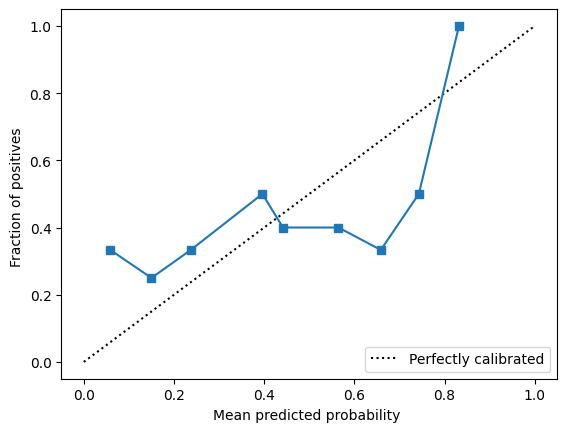

In [64]:
nb_features = 3

# load data 
X_madrid, y_madrid, madrid_features_list = get_xy(os.path.join(madrid_folder_path, table), os.path.join(madrid_folder_path, madrid_outcome_csv)) # Load the dataset
znorm_scaler = StandardScaler()
X_madrid = znorm_scaler.fit_transform(X_madrid)
best_features = load_selected_features(icm_results_file, table, feat_sel_algo, pred_algo, outcome, nb_features) # get previously selected features
sel_features_madrid, X_filtered_madrid = fsa.filter_dataset3(X_madrid, best_features, nb_features, madrid_features_list)
model_path = models_folder + table + "_" + feat_sel_algo + "_" + pred_algo + "_" + str(nb_features) + ".joblib"
loaded_model = joblib.load(model_path)
y_madrid = np.array(y_madrid).reshape(-1, 1).ravel() # convert to numpy array

# make predictions
y_prob = loaded_model.predict_proba(X_filtered_madrid)[:, 1]

# calibration curve
prob_true, prob_pred = calibration_curve(y_madrid, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

### Best train AUC
#### Display

In [65]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='train_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='train_auc')

Table: simu_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_VoxelVolume', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterSlice'], Parameters: {}
  Mean train_auc: 0.998, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean train_auc: 0.98, Feature Selection Algorithm: RF, Prediction Algorithm: ADABOOST, Features: ['original_shape_VoxelVolume', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterSlice'], Parameters: {}

Table: f1_gtv.csv
  Mean train_auc: 1.0, Feature Selection Algorithm: RF, Prediction Algorithm: BAGG, Features: ['original_shape_LeastAxisLength', 'original_shape_VoxelVolume', 'original_glszm_ZoneEntropy'], Parameters: {}
  Mean train_auc: 0.999, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Features: ['original_shape_Maximum2DDiameterRow'], Parameters

#### Scatter plot

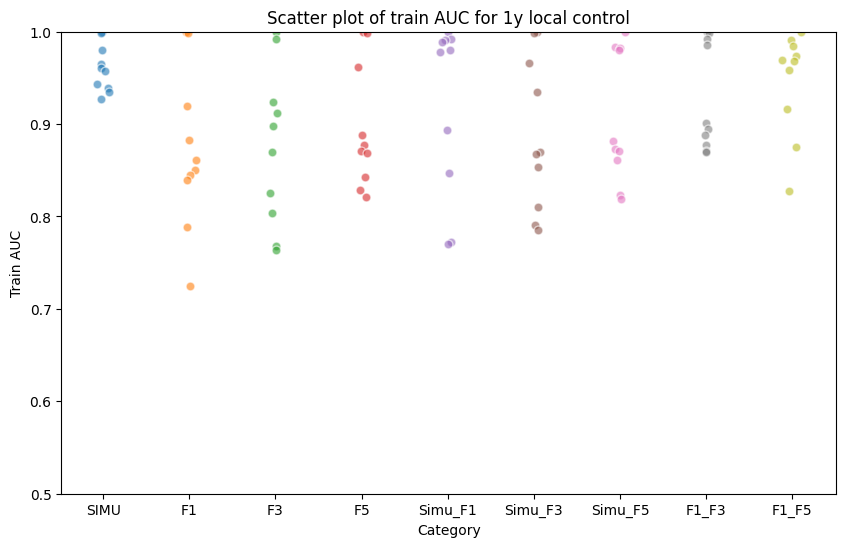

In [66]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of train AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Train AUC')
plt.show()


### Best test AUC
#### Display

In [67]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_auc', k = 10)
analysis_functions.print_top_results(top_results, metric='test_auc')

Table: simu_gtv.csv
  Mean test_auc: 0.631, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_VoxelVolume'], Parameters: {}
  Mean test_auc: 0.625, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: RF, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_auc: 0.598, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: QDA, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}

Table: f1_gtv.csv
  Mean test_auc: 0.618, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: QDA, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_auc: 0.604, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: LOGREGRIDGE, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_auc: 0.59, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: LOGREGRIDGE, Features: ['original_s

#### Scatter plot

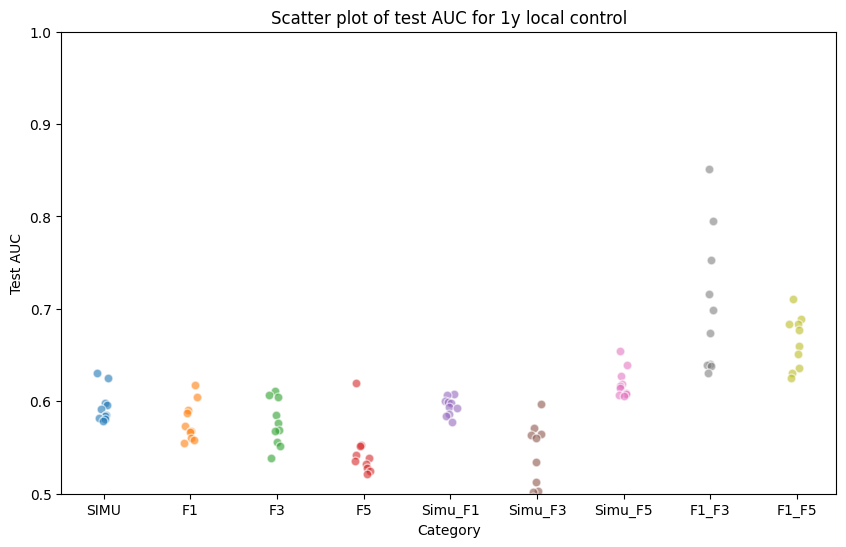

In [68]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test AUC for 1y local control')
plt.ylim([0.5, 1])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test AUC')
plt.show()


### Best test brier loss
#### Display

In [69]:
top_results = analysis_functions.get_top_results(results, delta_rad_tables, feat_sel_algo_list, pred_algo_list, outcome, metric='test_brier_loss', k = 10)
analysis_functions.print_top_results(top_results, metric='test_brier_loss')

Table: simu_gtv.csv
  Mean test_brier_loss: 0.241, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_brier_loss: 0.243, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_VoxelVolume', 'original_shape_Sphericity'], Parameters: {}
  Mean test_brier_loss: 0.247, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_shape_VoxelVolume'], Parameters: {}

Table: f1_gtv.csv
  Mean test_brier_loss: 0.24, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: PSVM, Features: ['original_shape_Maximum2DDiameterRow'], Parameters: {}
  Mean test_brier_loss: 0.242, Feature Selection Algorithm: RF, Prediction Algorithm: PSVM, Features: ['original_shape_LeastAxisLength'], Parameters: {}
  Mean test_brier_loss: 0.246, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: P

#### Scatter plot

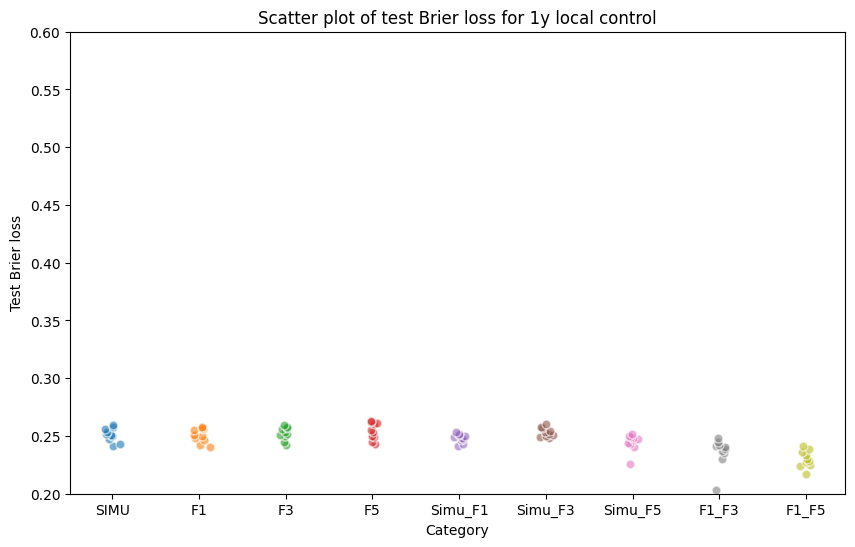

In [70]:
plt.figure(figsize=(10, 6))
data = analysis_functions.get_top_results_to_plot(top_results)

# Add jitter to the x-axis positions for better visualization
for i, (category, values) in enumerate(data.items()):
    x = np.random.normal(i + 1, 0.04, size=len(values))  # Adding jitter
    plt.scatter(x, values, alpha=0.6, edgecolors='w', s=40)

plt.title(f'Scatter plot of test Brier loss for 1y local control')
plt.ylim([0.2, 0.6])
plt.xticks(range(1, len(data) + 1), nice_tables)
plt.xlabel('Category')
plt.ylabel('Test Brier loss')
plt.show()


### Spe and Sens

In [71]:
analysis_functions.find_perf_alg(results, delta_rad_tables, [outcome], feat_sel_algo_list, pred_algo_list, metric='sens_spec', threshold=0.65)

Table: f1_f3_gtv.csv, Outcome: nine_months_metastatic_status, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: RF, Number of Features: 3, '
'                                           TEST AUC: 0.8506567132118311, Sensitivity: 0.7333333333333331, Specificity: 0.818181818181818, '
'                                           Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_MajorAxisLength', 'original_glszm_LargeAreaHighGrayLevelEmphasis']
Table: f1_f3_gtv.csv, Outcome: nine_months_metastatic_status, Feature Selection Algorithm: ANOVA_K_BEST, Prediction Algorithm: BAGG, Number of Features: 3, '
'                                           TEST AUC: 0.7529270240793151, Sensitivity: 0.7333333333333331, Specificity: 0.6818181818181811, '
'                                           Features: ['original_shape_Maximum2DDiameterRow', 'original_shape_MajorAxisLength', 'original_glszm_LargeAreaHighGrayLevelEmphasis']
